In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
from sklearn.utils import class_weight
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob
from PIL import ImageFile       

from keras.preprocessing import image                  
from tqdm import tqdm

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras import applications
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import keras
from sklearn.metrics import accuracy_score
from vecstack import stacking
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.models import Sequential
from keras.models import Model
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
from keras import optimizers, losses, activations, models
from keras.layers import Convolution2D, Dense, Input, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Concatenate
from keras.layers import Flatten
from keras.layers import Dense
from keras.preprocessing.image import ImageDataGenerator, load_img
import os
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
print(os.listdir("../input"))

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['chest_xray_kag']
['chest_xray_kag']


Using TensorFlow backend.


In [2]:
print(os.listdir("../input/chest_xray_kag/chest_xray"))

['test', 'val', 'train']


In [3]:
def load_dataset(path):
    data = load_files(path)
    chest_files = np.array(data['filenames'])
    chest_targets = np_utils.to_categorical(np.array(data['target']), 2)
    return chest_files, chest_targets

In [4]:
train_files, train_targets = load_dataset('../input/chest_xray_kag/chest_xray/train')
valid_files, valid_targets = load_dataset('../input/chest_xray_kag/chest_xray/test')

In [5]:
def path_to_tensor(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)


In [6]:
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255

100%|██████████| 624/624 [00:05<00:00, 109.78it/s]


In [7]:
from keras import backend as K

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [8]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=( 224, 224,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


In [9]:
model.add(Flatten()) 
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [10]:
batch_size = 16
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)


test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
        '../input/chest_xray_kag/chest_xray/train',  
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='binary')  
validation_generator = test_datagen.flow_from_directory(
        '../input/chest_xray_kag/chest_xray/test',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
y_ints = [y.argmax() for y in train_targets]

In [ ]:
class_weights = class_weight.compute_class_weight('balanced',np.unique(y_ints),y_ints)

In [11]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch=2000 // batch_size,
        epochs=15,
        validation_data=validation_generator,
        validation_steps=800 // batch_size)
model.save_weights('first_try.h5')

Epoch 1/15
125/125 [==============================] - 57s 455ms/step - loss: 0.4755 - acc: 0.7955 - val_loss: 1.0036 - val_acc: 0.6913
Epoch 2/15
125/125 [==============================] - 49s 391ms/step - loss: 0.3211 - acc: 0.8660 - val_loss: 0.5891 - val_acc: 0.7638
Epoch 3/15
125/125 [==============================] - 49s 396ms/step - loss: 0.2855 - acc: 0.8835 - val_loss: 0.5704 - val_acc: 0.7325
Epoch 4/15
125/125 [==============================] - 50s 403ms/step - loss: 0.2972 - acc: 0.8695 - val_loss: 0.4472 - val_acc: 0.7913
Epoch 5/15
125/125 [==============================] - 48s 387ms/step - loss: 0.2722 - acc: 0.8810 - val_loss: 0.5858 - val_acc: 0.7525
Epoch 6/15
125/125 [==============================] - 50s 397ms/step - loss: 0.2535 - acc: 0.8980 - val_loss: 0.3475 - val_acc: 0.8413
Epoch 7/15
125/125 [==============================] - 50s 403ms/step - loss: 0.2590 - acc: 0.9010 - val_loss: 0.6776 - val_acc: 0.7863
Epoch 8/15
125/125 [==============================] - 5

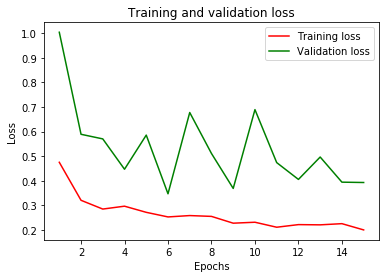

In [12]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, color='red', label='Training loss')
plt.plot(epochs, val_loss, color='green', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

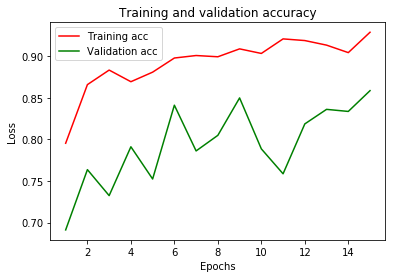

In [13]:
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, color='red', label='Training acc')
plt.plot(epochs, val_acc, color='green', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()